<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41564 entries, 0 to 41563
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        41564 non-null  object
 1   customer_id        41564 non-null  int64 
 2   review_id          41564 non-null  object
 3   product_id         41564 non-null  object
 4   product_parent     41564 non-null  int64 
 5   product_title      41564 non-null  object
 6   product_category   41564 non-null  object
 7   star_rating        41564 non-null  int64 
 8   helpful_votes      41564 non-null  int64 
 9   total_votes        41564 non-null  int64 
 10  vine               41564 non-null  object
 11  verified_purchase  41564 non-null  object
 12  review_headline    41563 non-null  object
 13  review_body        41561 non-null  object
 14  review_date        41561 non-null  object
dtypes: int64(5), object(10)
memory usage: 4.8+ MB
None
  marketplace  customer_id       rev

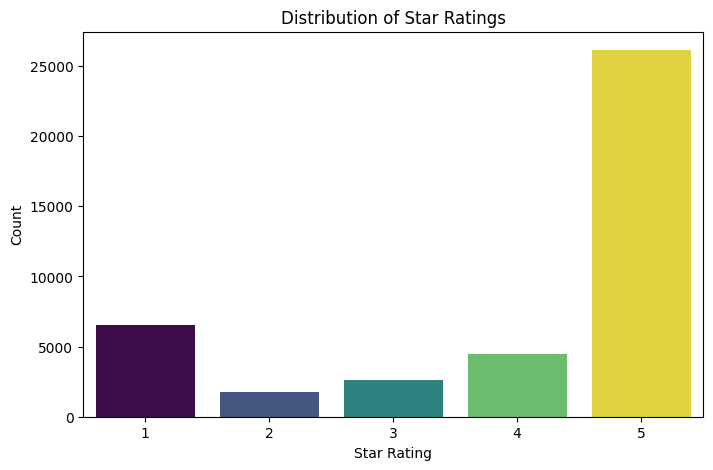

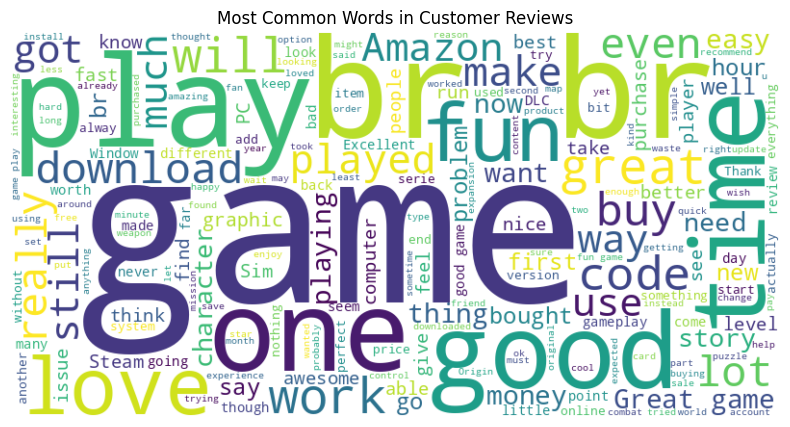

Model Accuracy: 0.9198149575944488
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1663
           1       0.93      0.97      0.95      6119

    accuracy                           0.92      7782
   macro avg       0.90      0.86      0.87      7782
weighted avg       0.92      0.92      0.92      7782



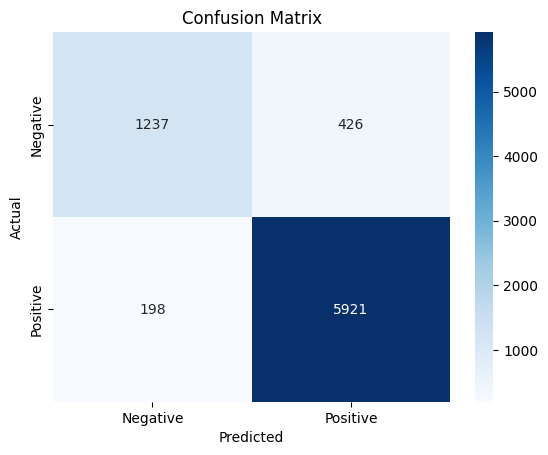

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("amazon_reviews_us_Digital_Video_Games_v1_00.csv")

# Display basic info
print(df.info())
print(df.head())

# Check for missing values in the dataset
print(df.isnull().sum())
# Drop rows with missing values in review_body
df.dropna(subset=['review_headline','review_body','review_date'], inplace=True)
# Verify missing values after dropping
print(df.isnull().sum())

# EDA - Plot distribution of star ratings
plt.figure(figsize=(8,5))
sns.countplot(x=df['star_rating'], palette='viridis', hue=df['star_rating'], legend=False)
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.title("Distribution of Star Ratings")
plt.show()

# EDA - Combine all review texts into one large string
text = " ".join(review for review in df['review_body'].dropna())
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
# Plot the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Customer Reviews")
plt.show()

# Select relevant columns
df = df[['star_rating', 'review_body']]

# Convert star ratings into sentiment labels
# Ratings 4 and 5 -> Positive (1), 1 and 2 -> Negative (0), 3 -> Neutral (remove)
df = df[df['star_rating'] != 3]  # Remove neutral reviews
df['sentiment'] = df['star_rating'].apply(lambda x: 1 if x > 3 else 0)

# Drop the original star_rating column
df.drop(columns=['star_rating'], inplace=True)

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df['clean_review'] = df['review_body'].apply(preprocess_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:}")

# Display classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
